In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Matérn and Heat Kernels on Hamming Graphs

This notebook shows how to define and evaluate kernels on q-ary Hamming graphs $H(d,q)$ for modeling data encoded as categorical vectors with kernels that respect the geometry of the Hamming distance.

**Note:** When $q=2$, the Hamming graph $H(d,2)$ reduces to the hypercube graph $C^d = \{0, 1\}^d$ (see `HypercubeGraph.ipynb`).

At the very end of the notebook we also show how to construct *approximate finite-dimensional feature maps* for the kernels on the Hamming graph and how to use these to efficiently sample the Gaussian processes $\mathrm{GP}(0, k)$.

**Note:** the points on the Hamming graph $H(d,q)$ are integer vectors of size $d$ where each component takes values in $\{0, 1, ..., q-1\}$ (`array`s of the suitable backend).

We use the **numpy** backend here.


<!--TABLE OF CONTENTS-->
## Contents
- [**Basics**](#Basics)
  - [Defining a Space](#Defining-a-Space)
  - [Defining a Kernel](#Defining-a-Kernel)
  - [Evaluating Kernels on Random Inputs](#Evaluating-Kernels-on-Random-Inputs)
  - [Visualizing Kernels](#Visualizing-Kernels)
- [**Feature Maps and Sampling**](#Feature-Maps-and-Sampling)
  - [Defining a Feature Map](#Defining-a-Feature-Map)
  - [Efficient Sampling using Feature Maps](#Efficient-Sampling-using-Feature-Maps)
- [**Citation**](#Citation)

## Basics

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import HammingGraph
from geometric_kernels.kernels import MaternGeometricKernel

# We use networkx to visualize graphs
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.
/opt/miniconda3/envs/geometrik/lib/python3.11/site-packages/spherical_harmonics/fundamental_set.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


### Defining a Space

First we create a GeometricKernels `space` that corresponds to the 4-dimensional ternary Hamming graph $H(4,3)$, where each coordinate takes values in $\{0, 1, 2\}$.

In [3]:
hamming_graph = HammingGraph(4,3)

### Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `hamming_graph` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on the Hamming graph space can be found on this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/TODO.html).

In [4]:
kernel = MaternGeometricKernel(hamming_graph)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not provide the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [5]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array([inf]), 'lengthscale': array([1.])}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params` we define below.

**Note:** like in the Euclidean or the manifold case, and unlike the general graph case, the $1/2, 3/2, 5/2$ are reasonable values of $\nu$.

In [6]:
params["lengthscale"] = np.array([2.0])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])

params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

### Evaluating Kernels on Random Inputs

We start by sampling `3` (uniformly) random points on our graph.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [7]:
key = np.random.RandomState(1234)

key, xs = hamming_graph.random(key, 3)

print(xs, xs.dtype)

[[0 1 1 2]
 [2 0 0 2]
 [2 2 1 1]] int32


Now we evaluate the two kernel matrices.

In [8]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

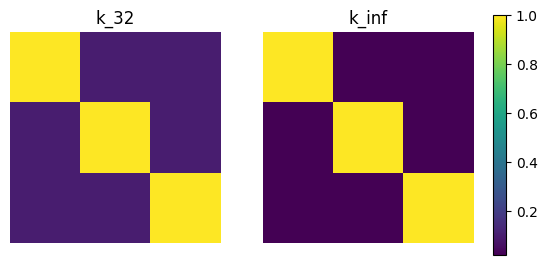

In [9]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Visualizing Kernels

Here we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
We define `base_point` and `other_points` in the next cell.

In [10]:
import itertools
base_point = np.array([0]*4)[None, :]  # choosing a fixed node for kernel visualization
other_points = np.array([list(i) for i in itertools.product([0, 1, 2], repeat=4)])

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [11]:
values_32  = kernel.K(params_32,  base_point,
                              other_points).flatten()
values_inf = kernel.K(params_inf, base_point,
                              other_points).flatten()

We prepare the networkx graph for visualizing the space

In [12]:
def hamming_graph_nx(d, q):
    """Create q-ary Hamming graph of dimension d."""
    G = nx.Graph()
    vertices = list(itertools.product(range(q), repeat=d))
    G.add_nodes_from(range(len(vertices)))
    
    for i, v1 in enumerate(vertices):
        for j, v2 in enumerate(vertices):
            if i < j and sum(a != b for a, b in zip(v1, v2)) == 1:
                G.add_edge(i, j)
    return G

nx_graph = hamming_graph_nx(4, 3)  # 81 vertices
pos = nx.spring_layout(nx_graph, seed=42)  # Auto-generate layout

Finally, we visualize the kernels

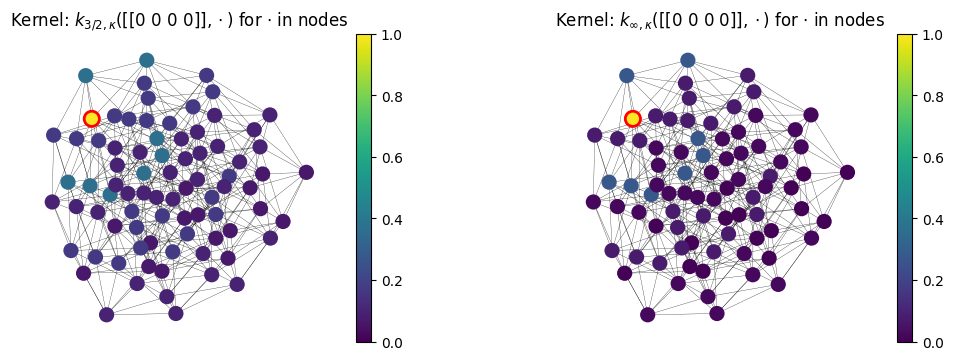

In [13]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(0.0, values_32.min(), values_inf.min())
vmax = max(1.0, values_32.max(), values_inf.max())


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*nx_graph.number_of_nodes()
edgecolors[0] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos, 'node_size': 120, 'width': 0.2}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.))

# Plot kernel values 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_aspect(1)
ax1.set_title('Kernel: $k_{3/2, \kappa}($%s$, \cdot)$ for $\cdot$ in nodes' % str(base_point))

# Plot kernel values inf
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_aspect(1)
ax2.set_title('Kernel: $k_{\infty, \kappa}($%s$, \cdot)$ for $\cdot$ in nodes' % str(base_point))


plt.show()

## Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on the Hamming graph $H(d,q)$, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

### Defining a Feature Map

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [14]:
from geometric_kernels.kernels import default_feature_map
from geometric_kernels.utils.utils import make_deterministic

feature_map = default_feature_map(kernel=kernel)
feature_map = make_deterministic(feature_map, key=key)

key, features = feature_map(xs, params_32, key=key)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For Hamming graphs, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element contains the updated `key` for randomized feature maps.
For `default_feature_map` on a `HammingGraph` space, the feature map is *randomized* (using `RandomPhaseFeatureMapCompact`), so the first element is the updated random state.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [15]:
# xs are random points from above
_, embedding = feature_map(xs, params_32)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (3, 4)):
[[0 1 1 2]
 [2 0 0 2]
 [2 2 1 1]]

emedding (shape = (3, 15000)):
[[ 0.00701236 -0.00344909 -0.00625436 ... -0.00625436  0.00705406
  -0.00205084]
 [ 0.00715692 -0.00352019 -0.00638329 ... -0.00638329 -0.00575958
   0.00418624]
 [ 0.00690437  0.0271678   0.04926436 ...  0.01231609 -0.00555634
  -0.00807703]]

||k(xs, xs) - phi(xs) * phi(xs)^T|| = 0.016708524516172243


### Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [16]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[-172.18988516 -134.87645627]
 [-221.5365812  -297.66287804]
 [ 121.27478634 -446.6551314 ]]


#### Visualizing Samples
Here we visualize samples as functions on a graph.

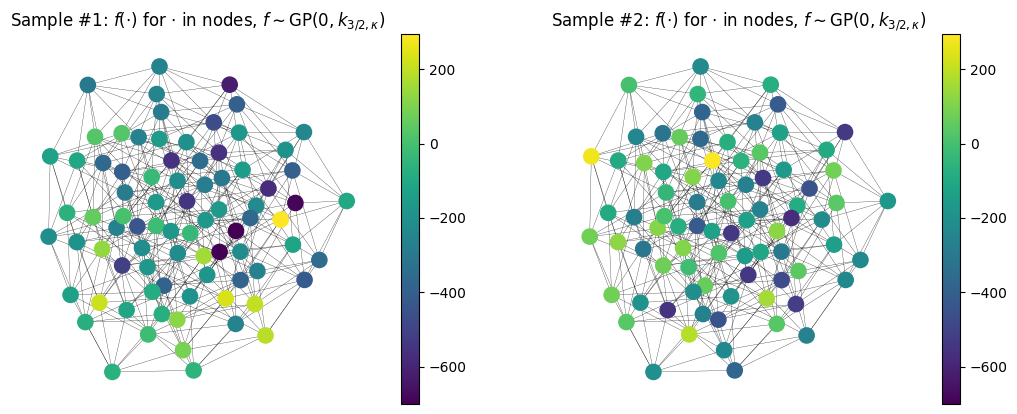

In [17]:
key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(sample1.min(), sample2.min())
vmax = max(sample1.max(), sample2.max())

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos, 'node_size': 120, 'width': 0.2}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

# Plot sample #1
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=sample1,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in nodes, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Plot sample #2
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=sample2,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in nodes, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')

plt.show()

## Citation

If you are using the HammingGraph space and GeometricKernels, please consider citing

```
@article{mostowsky2024,
      title = {The GeometricKernels Package: Heat and Matérn Kernels for Geometric Learning on Manifolds, Meshes, and Graphs},
      author = {Peter Mostowsky and Vincent Dutordoir and Iskander Azangulov and Noémie Jaquier and Michael John Hutchinson and Aditya Ravuri and Leonel Rozo and Alexander Terenin and Viacheslav Borovitskiy},
      year = {2024},
      journal = {arXiv:2407.08086},
}
```

```
@inproceedings{doumont2025,
    title = {Omnipresent Yet Overlooked: Heat Kernels in Combinatorial Bayesian Optimization},
    author = {Colin Doumont and Victor Picheny and Viacheslav Borovitskiy and Henry Moss},
    booktitle = {Advances in Neural Information Processing Systems},
    year = {2025},
}
```

```
@inproceedings{borovitskiy2023,
  title={Isotropic Gaussian Processes on Finite Spaces of Graphs},
  author={Borovitskiy, Viacheslav and Karimi, Mohammad Reza and Somnath, Vignesh Ram and Krause, Andreas},
  booktitle={International Conference on Artificial Intelligence and Statistics},
  year={2023},
}
```

```
@inproceedings{kondor2002,
    title={Diffusion Kernels on Graphs and Other Discrete Structures},
    author={Kondor, Risi Imre and Lafferty, John},
    booktitle={International Conference on Machine Learning},
    year={2002}
}
```